In [ ]:
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install nltk
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install imblearn
!{sys.executable} -m pip install imbalanced-learn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# read in data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')


# Visualize Data Before Preprocessing

In [3]:
# explore data
print(train_data.head())
print(train_data.shape)

# subtract 2 from the number of columns to account for the 'id' and 'label'(target) columns
print(f"Training examples: {train_data.shape[0]}, Testing examples: {test_data.shape[0]}, Attributes: {train_data.shape[1] - 2}")
print(train_data.describe())
print(train_data['label'].value_counts())


   Unnamed: 0  label                                               text
0           0      4  dr. goldberg offers everything i look for in a...
1           1      1  Unfortunately, the frustration of being Dr. Go...
2           2      3  Been going to Dr. Goldberg for over 10 years. ...
3           3      3  Got a letter in the mail last week that said D...
4           4      0  I don't know what Dr. Goldberg was like before...
(650000, 3)
Training examples: 650000, Testing examples: 50000, Attributes: 1
          Unnamed: 0          label
count  650000.000000  650000.000000
mean   324999.500000       2.000000
std    187638.981824       1.414215
min         0.000000       0.000000
25%    162499.750000       1.000000
50%    324999.500000       2.000000
75%    487499.250000       3.000000
max    649999.000000       4.000000
label
4    130000
1    130000
3    130000
0    130000
2    130000
Name: count, dtype: int64


### Labeled Review Chart
 The chart below shows uniform distribution of sentiment analysis and class balance, showing that the model will not be more biased towared more common classes.

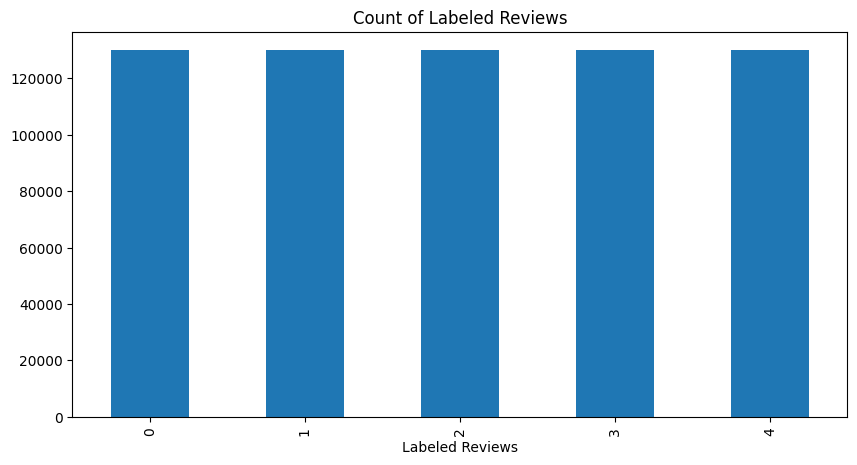

In [3]:
# Quick EDA
ax = train_data['label'].value_counts().sort_index().plot(kind='bar', title="Count of Labeled Reviews", figsize=(10, 5))
ax.set_xlabel("Labeled Reviews")
plt.show()

In [4]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

def preprocess_text_1(text):
    '''
    this function removes punctuation, converts text to lowercase, removes stopwords, and returns the cleaned text
    in the form of a string
    '''
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    text = text.split()
    text = [word for word in text if word not in stop_words]
    text = ' '.join(text)
    return text

train_data['text'] = train_data['text'].apply(preprocess_text_1)
test_data['text'] = test_data['text'].apply(preprocess_text_1)


[nltk_data] Downloading package stopwords to /Users/tay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


next, we will convert text to numerical representations

why?
- most ML algorithms will be working with numerical data as input so the machine can understand the data and use it for the algorithm
- this conversion is called feature extraction or vectorization

why are we using TF-IDF below?
- Term Frequency-Inverse Document Frequency is a popular method for converting text into numerical vectors. it assigns weights to each word based on how important or relevant it is in the corpus. words that appear frequently in a specific document (text review) but infrequently across the entire corpus are given higher weights, as they are more informative for that specific document.
- TF-IDF is widely used because it captures the relative importance of words in a doc., which can be beneficial for tasks like sentiment analysis, where the presence of certain words can strongly indicate the sentiment.

what are other models we could use, and would it be smart to test out using different methods?
- i want to compare these different text vectorization methods
    1. bag-of-words : simple method, counts the occurrences of each word in a document, representing it as a vector of word frequencies
    2. word embeddings : method represents words as dense vectors that capture semantic and syntactic info, such as Word2Vec or GloVe embeddings.
    3. n-gram models : instead of considering single words, n-grams capture sequences of n consecutive words, which can provide more context.

In [5]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

'''this converts text into TF-IDF vectors, which are used as features for the model'''
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_data['text'])
X_test = vectorizer.transform(test_data['text'])
y_train = train_data['label']
y_test = test_data['label']

# Validation Set
we want to separate the data into a validation set to tune hyperparameters and evaluate model's performance during training. this validation set acts as an unbiased proxy for the test set, allowing you to tune the model's hyperparmaters (regularization strength, number of trees, etc.) and prevent overfitting to the training data.

In [6]:
# lets separate the training data into a validation set
from sklearn.model_selection import train_test_split
# we use random_state to ensure reproducibility - it controls the randomness of the split. 42 is a common value
# you guarantee that the output of Run 1 will be equal to the output of Run 2, i.e. your split will be always the same
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Visualizing the Preprocessed Data
to get a better understanding of what it looks like before moving on

In [7]:
print('first 5 examples from training data')
#print(X_train[:5])
print(train_data[['text', 'label']].head())
print()
print(f'shape of training data: {X_train.shape}')
print(f'shape of validation data: {X_val.shape}')
print(f'shape of test data: {X_test.shape}')
print()
print('lbel distribution in training data')
print(train_data['label'].value_counts())
print('label distribution in test data')
print(test_data['label'].value_counts())
print()
print('example vectors from training data:')
print(X_train[:3])
'''
print the first 3 examples. each sample is represented as a vector with columns.
X_train is the vectorized text data, each row represents on text sample (review) and each column represents a feature (word in the TF-IDF vector)
[:3] is the slicing which selects the first 3 samples
the multiple lines for each sample is that the vectors are high dimension and python prints them on on multiple lines for readability
'''

first 5 examples from training data
                                                text  label
0  dr goldberg offers everything look general pra...      4
1  unfortunately frustration dr goldbergs patient...      1
2  going dr goldberg years think one st patients ...      3
3  got letter mail last week said dr goldberg mov...      3
4  dont know dr goldberg like moving arizona let ...      0

shape of training data: (520000, 790337)
shape of validation data: (130000, 790337)
shape of test data: (50000, 790337)

lbel distribution in training data
label
4    130000
1    130000
3    130000
0    130000
2    130000
Name: count, dtype: int64
label distribution in test data
label
0    10000
2    10000
1    10000
3    10000
4    10000
Name: count, dtype: int64

example vectors from training data:
  (0, 14481)	0.3521445436384422
  (0, 520172)	0.22519277351182185
  (0, 506118)	0.21425344076291708
  (0, 438206)	0.17074109239568955
  (0, 747013)	0.1685015538587805
  (0, 358168)	0.3609007648115094

'\nprint the first 3 examples. each sample is represented as a vector with columns.\nX_train is the vectorized text data, each row represents on text sample (review) and each column represents a feature (word in the TF-IDF vector)\n[:3] is the slicing which selects the first 3 samples\nthe multiple lines for each sample is that the vectors are high dimension and python prints them on on multiple lines for readability\n'

# Decision Tree Classifer

In [9]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

# Evaluate Model Performance

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

predictions = dt_model.predict(X_val)
print(accuracy_score(y_val, predictions))
print(classification_report(y_val, predictions))

0.3887307692307692
              precision    recall  f1-score   support

           0       0.53      0.53      0.53     26100
           1       0.31      0.31      0.31     25992
           2       0.31      0.31      0.31     26130
           3       0.32      0.32      0.32     26048
           4       0.46      0.47      0.47     25730

    accuracy                           0.39    130000
   macro avg       0.39      0.39      0.39    130000
weighted avg       0.39      0.39      0.39    130000



# Results Analysis
The performance shows similar results across each class, which means this is balanced and the model is not biased towards any class. This could mean, however, that the model can't really distinguish between the classes. The overall accuracy is about 38.87%.

## Model Complexity
Reasons for this could be model complexity.  If the tree is too complex, it could be overfitting. Pruning the tree would help here. To prune the tree we could limit the depth or set a minimum samples per leaf. If the tree is too simple, it's not capturing necessary patterns in data. To ensure more patterns are captured, we could increase the depth.

## Feature Engineering
We could try to use better features that could capture the sentiment more effectively:
- N-grams : use bi-grams or tri-grams to capture context
- Word Embeddings: use pre-trained embeddings like Word2Vec, GloVe, or BERT embeddings 

## Hyperparameter Tuning
We can try using a systematic search for the best hyperparameters using grid search or random search 
- Grid Search : test randge of values for parameters: 'max_depth', 'min_samples_split', and 'min_samples_leaf'
- Random Search : sample wider range of values. typically this is more efficient than grid search

## Other Things To Try:
- Remove stop words
- use stemming or lemmatization, which reduce words to their root form
    - use nltk.stem.WordNetLemmatizer
- Instead of removing all characters except letters, include punctuation like '?' or '!' which can express sentiment
- Tweak the parameters of the TF-IDF like 'ngram_range', 'max_df', 'min_df', and 'max_features'

# Implementation of Decision Tree Take 2

In [3]:
import nltk
import re
import pandas as pd
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

# reload original data
# TODO: could read in once and every time I apply a preprocessing function, name the variable after which preprocessing function was applied
# that way I can keep track of the data at each stage of preprocessing and just load the original data once
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

def preprocess_text_2(text):
    '''
    this function removes all non-alphabetic characters and leaves only words. 
    it then coverts all text to lowercase for consistency and splits the text into words.
    it then lemmatizes the words to their root form.
    then it joins the words back together into a single string and returns the cleaned text
    '''
    text = re.sub(r'[\d\W]+', ' ', text)
    text = text.lower().split()
    text = [lemmatizer.lemmatize(word) for word in text]

    return ' '.join(text)

train_data['text'] = train_data['text'].apply(preprocess_text_2)
test_data['text'] = test_data['text'].apply(preprocess_text_2)

[nltk_data] Downloading package wordnet to /Users/tay/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report


In [ ]:
# TF-IDF Vectorization with bigrams and feature selection
# TF-IDF takes text data and converts it into a high dimensional vector representation
# set up to use uni-grams and bi-grams, remove words that appear in more than 95% of the documents, 
#    remove words that appear in less than 5 documents, and limit the number of features to 5000
# these 5000 dimensions are the "top" features as determined by the TF-IDF vectorizer
print("Starting TF-IDF Vectorization...")
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.95, min_df=5, max_features=5000)
X_train = vectorizer.fit_transform(train_data['text'])
X_test = vectorizer.transform(test_data['text'])
print("Completed TF-IDF Vectorization.")


In [ ]:
# Dimensionality Reduction
# do this reduce the feature space which can help the model generalize better. this is making the model less complex
# so we are further reducing the dimnesionality of the data from 5000 to 1000 while trying to preserve as much information as possible
from sklearn.decomposition import IncrementalPCA

print("Starting Dimensionality Reduction with IncrementalPCA...")
n_batches = 1000  # or another number that fits your memory constraints
ipca = IncrementalPCA(n_components=1000, batch_size=n_batches)
X_train_ipca = ipca.fit_transform(X_train)
print(f"Explained variance ratio: {ipca.explained_variance_ratio_.sum()}")
X_test_ipca = ipca.transform(X_test)
print("Completed Dimensionality Reduction.")

In [6]:
# Splitting the data into training and validation sets with stratification
print("Splitting the data into training and validation sets...")
X_train_ipca, X_val_ipca, y_train, y_val = train_test_split(X_train_ipca, train_data['label'], test_size=0.2, random_state=42, stratify=train_data['label'])
print("Completed splitting.")

# Hyperparameter tuning
print("Starting Hyperparameter Tuning with GridSearchCV...")
dt_params = {
    'max_depth': 20,
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'criterion': 'gini'
}
dt_model = DecisionTreeClassifier(**dt_params, random_state=42)
#clf = GridSearchCV(dt, dt_params, cv=3, scoring='accuracy', n_jobs=7)
#clf.fit(X_train_ipca, y_train)
dt_model.fit(X_train_ipca, y_train)
print("Completed Hyperparameter Tuning.")

print("Evaluating the best model...")
#best_dt_model = clf.best_estimator_
#predictions = best_dt_model.predict(X_val_ipca)
predictions = dt_model.predict(X_val_ipca)
print(f"Accuracy: {accuracy_score(y_val, predictions)}")
print(classification_report(y_val, predictions))

print("Refitting the best model on the entire dataset...")
#best_dt_model.fit(X_train_ipca, y_train)
print("Completed refitting.")

Starting TF-IDF Vectorization...
Completed TF-IDF Vectorization.
Starting Dimensionality Reduction with IncrementalPCA...
Explained variance ratio: 0.5741865389670022
Completed Dimensionality Reduction.
Splitting the data into training and validation sets...
Completed splitting.
Starting Hyperparameter Tuning with GridSearchCV...
Completed Hyperparameter Tuning.
Evaluating the best model...
Accuracy: 0.3540153846153846
              precision    recall  f1-score   support

           0       0.47      0.49      0.48     26000
           1       0.29      0.30      0.29     26000
           2       0.29      0.30      0.29     26000
           3       0.30      0.29      0.29     26000
           4       0.44      0.40      0.42     26000

    accuracy                           0.35    130000
   macro avg       0.36      0.35      0.35    130000
weighted avg       0.36      0.35      0.35    130000

Refitting the best model on the entire dataset...
Completed refitting.


In [7]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(512, 256, 128),  # 3 layers with 512, 256, and 128 neurons each
                    activation='relu',
                    solver='adam',
                    alpha=1e-4,  # regularization - L2 penalty (regularization term) parameter which helps in avoiding overfitting by penalizing weights with large magnitudes
                    batch_size=256,  # size of minibatches for stochastic optimizers - used in the optimization process to help converge faster
                    learning_rate_init=0.001,  # learning curve - step size in updating the weights
                    max_iter=200,
                    random_state=42)

# train model on the training data
mlp.fit(X_train_ipca, y_train)

# evaluate the model
predictions = mlp.predict(X_val_ipca) 
print(f"Accuracy: {accuracy_score(y_val, predictions)}")
print(classification_report(y_val, predictions))


Accuracy: 0.5188769230769231
              precision    recall  f1-score   support

           0       0.67      0.66      0.66     26000
           1       0.45      0.45      0.45     26000
           2       0.43      0.42      0.43     26000
           3       0.43      0.45      0.44     26000
           4       0.63      0.61      0.62     26000

    accuracy                           0.52    130000
   macro avg       0.52      0.52      0.52    130000
weighted avg       0.52      0.52      0.52    130000



In [8]:
mlp_2 = MLPClassifier(hidden_layer_sizes=(512, 128, 64),  # More layers and different sizes
                    activation='tanh',                 # Changing the activation function
                    solver='adam',                     # Keeping 'adam' but you can try 'sgd' or 'lbfgs'
                    alpha=1e-5,                        # Adjusting regularization
                    learning_rate_init=0.001,          # Initial learning rate
                    batch_size=128,                    # Smaller batch size
                    learning_rate='adaptive',          # Learning rate schedule
                    early_stopping=True,               # Enable early stopping
                    max_iter=200,                      # Max number of epochs
                    random_state=42)

# Train and evaluate the MLP as before
# Train the MLP on the PCA-reduced data
mlp_2.fit(X_train_ipca, y_train)

# Evaluate the MLP
predictions = mlp_2.predict(X_val_ipca)  # Assuming that you've transformed your validation set with PCA as well
print(f"Accuracy: {accuracy_score(y_val, predictions)}")
print(classification_report(y_val, predictions))

Accuracy: 0.5945538461538461
              precision    recall  f1-score   support

           0       0.71      0.76      0.73     26000
           1       0.53      0.50      0.52     26000
           2       0.51      0.52      0.52     26000
           3       0.53      0.46      0.49     26000
           4       0.66      0.73      0.69     26000

    accuracy                           0.59    130000
   macro avg       0.59      0.59      0.59    130000
weighted avg       0.59      0.59      0.59    130000



In [10]:
# split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, train_data['label'], test_size=0.2, random_state=42, stratify=train_data['label'])

In [11]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Using raw TF-IDF features - X_train and X_val
mlp = MLPClassifier(
    hidden_layer_sizes=(1024, 512, 256),  # Expanded capacity with more layers and units
    activation='relu',                     # Using ReLU activation function
    solver='sgd',                          # Switching to SGD optimizer
    alpha=1e-4,                            # Regularization term
    batch_size=128,                        # Size of minibatches
    learning_rate='adaptive',              # Adaptive learning rate
    learning_rate_init=0.01,               # Higher initial learning rate
    momentum=0.9,                          # Momentum for SGD
    n_iter_no_change=10,                   # Number of iterations with no improvement to wait before stopping
    max_iter=500,                          # Allowing more iterations
    random_state=42,
    early_stopping=True                    # Enable early stopping
)

print("Starting MLP training...")
mlp.fit(X_train, y_train)  # Fit the model on the full TF-IDF vectors

print("Evaluating the MLP...")
predictions = mlp.predict(X_val)  # Evaluate on the validation set
print(f"Accuracy: {accuracy_score(y_val, predictions)}")
print(classification_report(y_val, predictions))
print("Completed MLP training.")


Starting MLP training...
Evaluating the MLP...
Accuracy: 0.6117461538461538
              precision    recall  f1-score   support

           0       0.73      0.76      0.75     26000
           1       0.54      0.58      0.56     26000
           2       0.55      0.50      0.52     26000
           3       0.55      0.46      0.50     26000
           4       0.68      0.75      0.71     26000

    accuracy                           0.61    130000
   macro avg       0.61      0.61      0.61    130000
weighted avg       0.61      0.61      0.61    130000

Completed MLP training.


In [12]:
!{sys.executable} -m pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 3.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 MB 28.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 7.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 41.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.3/169.3 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 38.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.2/133.2 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.4/393.4 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 39.

In [4]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load the sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

def preprocess_text_3(texts, batch_size=128):
    """
    This function takes a list of texts and converts them into word embeddings.
    
    Parameters:
    texts (list): A list of strings.
    batch_size (int): The size of batches to process texts. Defaults to 128.
    
    Returns:
    np.ndarray: An array of sentence embeddings.
    """
    # Compute embeddings in batches
    embeddings = model.encode(texts, batch_size=batch_size, show_progress_bar=True)
    return np.array(embeddings)


train_embeddings = preprocess_text_3(train_data['text'].tolist())
test_embeddings = preprocess_text_3(test_data['text'].tolist())

Batches: 100%|██████████| 391/391 [04:57<00:00,  1.31it/s]


In [ ]:
X_train_embeddings, X_val_embeddings, y_train, y_val = train_test_split(
    train_embeddings, 
    train_data['label'], 
    test_size=0.2, 
    random_state=42, 
    stratify=train_data['label']
)

In [19]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

mlp = MLPClassifier(
    hidden_layer_sizes=(512, 256),  # Reduced complexity as embeddings are already feature-rich
    activation='relu',               # Common choice for activation function
    solver='adam',                   # Efficient optimizer
    alpha=1e-5,                      # Regularization parameter
    batch_size=64,                   # Batch size for training
    learning_rate_init=0.001,        # Initial learning rate
    max_iter=200,                    # Maximum number of training iterations
    random_state=42,                 # Random state for reproducibility
    early_stopping=True              # To prevent overfitting
)

print("Starting MLP training...")
mlp.fit(X_train_embeddings, y_train)

print("Evaluating the MLP...")
predictions = mlp.predict(X_val_embeddings)
accuracy = accuracy_score(y_val, predictions)
print(f"Accuracy: {accuracy}")
print(classification_report(y_val, predictions))


Starting MLP training...
Evaluating the MLP...
Accuracy: 0.5426846153846154
              precision    recall  f1-score   support

           0       0.69      0.71      0.70     26000
           1       0.46      0.50      0.48     26000
           2       0.47      0.38      0.42     26000
           3       0.44      0.52      0.48     26000
           4       0.67      0.60      0.63     26000

    accuracy                           0.54    130000
   macro avg       0.55      0.54      0.54    130000
weighted avg       0.55      0.54      0.54    130000



In [20]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(256, 256, 256),  # Adjusted architecture
    activation='relu',                    
    solver='adam',                        
    alpha=1e-6,                           # Adjusted regularization
    batch_size=256,                       # Adjusted batch size
    learning_rate='adaptive',
    learning_rate_init=0.005,             # Adjusted learning rate
    max_iter=500,                         
    random_state=42,
    early_stopping=True,
    n_iter_no_change=20,                  # More patience for early stopping
    shuffle=True,                         # Shuffle data during training
    verbose=True                          # For real-time updates
)

print("Starting MLP training...")
mlp.fit(X_train_embeddings, y_train)

print("Evaluating the MLP...")
predictions = mlp.predict(X_val_embeddings)
accuracy = accuracy_score(y_val, predictions)
print(f"Accuracy: {accuracy}")
print(classification_report(y_val, predictions))


Starting MLP training...
Iteration 1, loss = 1.09607862
Validation score: 0.534346
Iteration 2, loss = 1.05720251
Validation score: 0.537231
Iteration 3, loss = 1.03924978
Validation score: 0.536096
Iteration 4, loss = 1.02565714
Validation score: 0.542038
Iteration 5, loss = 1.01427587
Validation score: 0.541519
Iteration 6, loss = 1.00372097
Validation score: 0.542346
Iteration 7, loss = 0.99460339
Validation score: 0.543346
Iteration 8, loss = 0.98474722
Validation score: 0.541558
Iteration 9, loss = 0.97708578
Validation score: 0.542385
Iteration 10, loss = 0.96804657
Validation score: 0.537577
Iteration 11, loss = 0.96082322
Validation score: 0.534788
Iteration 12, loss = 0.95340865
Validation score: 0.538846
Iteration 13, loss = 0.94590561
Validation score: 0.538019
Iteration 14, loss = 0.93961664
Validation score: 0.534288
Iteration 15, loss = 0.93296934
Validation score: 0.534500
Iteration 16, loss = 0.92643198
Validation score: 0.532288
Iteration 17, loss = 0.92062893
Validati

In [21]:
mlp = MLPClassifier(
    hidden_layer_sizes=(512, 512, 256),  # Increased complexity
    activation='relu',
    solver='adam',
    alpha=1e-6,                          # Decreased regularization
    batch_size=128,                      # Increased batch size for stability
    learning_rate='adaptive',
    learning_rate_init=0.005,            # Increased initial learning rate for faster convergence
    max_iter=500,
    random_state=42,
    early_stopping=True,
    n_iter_no_change=20,                 # Increased patience for early stopping
    shuffle=True,
    verbose=True
)

print("Starting MLP training...")
mlp.fit(X_train_embeddings, y_train)  # Ensure correct dataset is used for training

print("Evaluating the MLP...")
predictions = mlp.predict(X_val_embeddings)  # Ensure correct dataset is used for evaluation
accuracy = accuracy_score(y_val, predictions)
print(f"Accuracy: {accuracy}")
print(classification_report(y_val, predictions))


Starting MLP training...
Iteration 1, loss = 1.09830630
Validation score: 0.529038
Iteration 2, loss = 1.05864261
Validation score: 0.531250
Iteration 3, loss = 1.04069166
Validation score: 0.535981
Iteration 4, loss = 1.02594769
Validation score: 0.536058
Iteration 5, loss = 1.01319610
Validation score: 0.536462
Iteration 6, loss = 1.00077886
Validation score: 0.539308
Iteration 7, loss = 0.98860957
Validation score: 0.534923
Iteration 8, loss = 0.97701138
Validation score: 0.533327
Iteration 9, loss = 0.96582819
Validation score: 0.530750
Iteration 10, loss = 0.95492898
Validation score: 0.531077
Iteration 11, loss = 0.94528638
Validation score: 0.531596
Iteration 12, loss = 0.93482196
Validation score: 0.531481
Iteration 13, loss = 0.92534444
Validation score: 0.525981
Iteration 14, loss = 0.91651570
Validation score: 0.520827
Iteration 15, loss = 0.90755530
Validation score: 0.522942
Iteration 16, loss = 0.89963139
Validation score: 0.522712
Iteration 17, loss = 0.89201097
Validati

In [25]:
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

# Apply SMOTE to generate synthetic samples for underrepresented classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_embeddings, y_train)

mlp = MLPClassifier(
    hidden_layer_sizes=(256, 256),
    activation='relu',
    solver='adam',
    alpha=1e-6,
    batch_size=128,
    learning_rate='adaptive',
    learning_rate_init=0.002,
    max_iter=500,
    random_state=42,
    early_stopping=True,
    n_iter_no_change=10,
    shuffle=True,
    verbose=True
)

print("Starting MLP training...")
mlp.fit(X_train_smote, y_train_smote)

print("Evaluating the MLP...")
predictions = mlp.predict(X_val_embeddings)
accuracy = accuracy_score(y_val, predictions)
print(f"Accuracy: {accuracy}")
print(classification_report(y_val, predictions))


Starting MLP training...
Iteration 1, loss = 1.08973635
Validation score: 0.526038
Iteration 2, loss = 1.04996238
Validation score: 0.531500
Iteration 3, loss = 1.03082357
Validation score: 0.538788
Iteration 4, loss = 1.01592058
Validation score: 0.538442
Iteration 5, loss = 1.00225040
Validation score: 0.540942
Iteration 6, loss = 0.98922393
Validation score: 0.538404
Iteration 7, loss = 0.97744157
Validation score: 0.539577
Iteration 8, loss = 0.96543807
Validation score: 0.536019
Iteration 9, loss = 0.95319704
Validation score: 0.535423
Iteration 10, loss = 0.94125079
Validation score: 0.533058
Iteration 11, loss = 0.93010410
Validation score: 0.533385
Iteration 12, loss = 0.92012071
Validation score: 0.528712
Iteration 13, loss = 0.90906760
Validation score: 0.523769
Iteration 14, loss = 0.89968201
Validation score: 0.525923
Iteration 15, loss = 0.89120890
Validation score: 0.523077
Iteration 16, loss = 0.88195956
Validation score: 0.522423
Validation score did not improve more th

In [26]:
mlp = MLPClassifier(
    hidden_layer_sizes=(512, 512, 256),  # Slightly increased complexity
    activation='relu',                    
    solver='adam',                        
    alpha=1e-5,                           # Adjust regularization if needed
    batch_size=128,                       # Fine-tune batch size
    learning_rate='adaptive',             
    learning_rate_init=0.001,             # Adjust initial learning rate if needed
    max_iter=500,                         # Increase if early stopping is too early
    random_state=42,                      
    early_stopping=True,                  
    n_iter_no_change=20,                  # Increase patience
    shuffle=True,                         
    verbose=True                          
)

print("Starting MLP training...")
mlp.fit(X_train_embeddings, y_train_smote)  # Use SMOTE adjusted training data

print("Evaluating the MLP...")
predictions = mlp.predict(X_val_embeddings)  # Validation on original unaltered validation set
accuracy = accuracy_score(y_val, predictions)
print(f"Accuracy: {accuracy}")
print(classification_report(y_val, predictions))


Starting MLP training...
Iteration 1, loss = 1.08906656
Validation score: 0.530635
Iteration 2, loss = 1.04467314
Validation score: 0.536019
Iteration 3, loss = 1.02197329
Validation score: 0.540596
Iteration 4, loss = 1.00224999
Validation score: 0.541058
Iteration 5, loss = 0.98253407
Validation score: 0.539096
Iteration 6, loss = 0.96123428
Validation score: 0.538192
Iteration 7, loss = 0.93897989
Validation score: 0.537615
Iteration 8, loss = 0.91529869
Validation score: 0.527481
Iteration 9, loss = 0.88964359
Validation score: 0.527846
Iteration 10, loss = 0.86413847
Validation score: 0.527827
Iteration 11, loss = 0.83782341
Validation score: 0.523500
Iteration 12, loss = 0.81278625
Validation score: 0.519885
Iteration 13, loss = 0.78755523
Validation score: 0.517500
Iteration 14, loss = 0.76350572
Validation score: 0.508558
Iteration 15, loss = 0.74145362
Validation score: 0.507962
Iteration 16, loss = 0.71974565
Validation score: 0.504154
Iteration 17, loss = 0.69898911
Validati

In [27]:
mlp = MLPClassifier(
    hidden_layer_sizes=(512, 512, 256),  # Continue with a slightly complex model
    activation='relu',                    
    solver='adam',                        
    alpha=1e-4,                           # Increase regularization slightly if needed
    batch_size=128,                       # Fine-tune batch size
    learning_rate='adaptive',             
    learning_rate_init=0.0005,            # Lower initial learning rate
    max_iter=500,                         # Allow for more iterations
    random_state=42,                      
    early_stopping=True,                  
    n_iter_no_change=25,                  # Increase patience
    shuffle=True,                         
    verbose=True                          
)

print("Starting MLP training...")
mlp.fit(X_train_embeddings, y_train_smote)  # Ensure you use the SMOTE-adjusted training data

print("Evaluating the MLP...")
predictions = mlp.predict(X_val_embeddings)  # Validate on the original unaltered validation set
accuracy = accuracy_score(y_val, predictions)
print(f"Accuracy: {accuracy}")
print(classification_report(y_val, predictions))


Starting MLP training...
Iteration 1, loss = 1.09154737
Validation score: 0.528865
Iteration 2, loss = 1.04365931
Validation score: 0.535096
Iteration 3, loss = 1.02139267
Validation score: 0.539269
Iteration 4, loss = 1.00238764
Validation score: 0.540731
Iteration 5, loss = 0.98432301
Validation score: 0.540346
Iteration 6, loss = 0.96569958
Validation score: 0.538692
Iteration 7, loss = 0.94567652
Validation score: 0.536154
Iteration 8, loss = 0.92438808
Validation score: 0.532635
Iteration 9, loss = 0.90193195
Validation score: 0.526962
Iteration 10, loss = 0.87770450
Validation score: 0.525923
Iteration 11, loss = 0.85211266
Validation score: 0.523250
Iteration 12, loss = 0.82569055
Validation score: 0.520212
Iteration 13, loss = 0.79956040
Validation score: 0.514442
Iteration 14, loss = 0.77422549
Validation score: 0.509615
Iteration 15, loss = 0.74874428
Validation score: 0.508942
Iteration 16, loss = 0.72401716
Validation score: 0.508481
Iteration 17, loss = 0.70114682
Validati

In [5]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the sentence transformer model for embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')

# Define a function for preprocessing text into embeddings
def preprocess_text_3(texts, batch_size=128):
    embeddings = model.encode(texts, batch_size=batch_size, show_progress_bar=True)
    return np.array(embeddings)

# Process the text data into embeddings
train_embeddings = preprocess_text_3(train_data['text'].tolist())
test_embeddings = preprocess_text_3(test_data['text'].tolist())

# Also, get TF-IDF features
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(train_data['text'])
X_test_tfidf = tfidf.transform(test_data['text'])

# Combine TF-IDF features with embeddings
X_train_combined = np.hstack((X_train_tfidf.toarray(), train_embeddings))
X_test_combined = np.hstack((X_test_tfidf.toarray(), test_embeddings))

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_combined, 
    train_data['label'], 
    test_size=0.2, 
    random_state=42, 
    stratify=train_data['label']
)

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


# Initialize the MLP
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    max_iter=1,  # We'll manually iterate over epochs
    warm_start=True,  # Keep training the same model
    solver='adam',
    random_state=42
)

# Define batch size and calculate number of batches
batch_size = 32
n_batches = int(np.ceil(X_train.shape[0] / batch_size))

# Training with manual mini-batches
for epoch in range(100):  # Replace with the number of epochs you want
    X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=epoch)
    
    for batch in range(n_batches):
        start = batch * batch_size
        end = start + batch_size
        X_batch, y_batch = X_train_shuffled[start:end], y_train_shuffled[start:end]
        mlp.partial_fit(X_batch, y_batch, classes=np.unique(y_train))

    # Early stopping logic here: evaluate on X_val, break if no improvement

# Evaluate the final model
predictions = mlp.predict(X_val)
accuracy = accuracy_score(y_val, predictions)
print(f"Final accuracy: {accuracy}")
print(classification_report(y_val, predictions))


# Plot the confusion matrix
cm = confusion_matrix(y_val, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Perform cross-validated predictions for ensembling
print("Starting cross-validated predictions for ensembling...")
cv_predictions = cross_val_predict(mlp, X_train, y_train, cv=5, method='predict_proba')

# Ensemble predictions by averaging probabilities
average_predictions = np.argmax(cv_predictions, axis=1)

# Evaluate ensemble performance
ensemble_accuracy = accuracy_score(y_train, average_predictions)
print(f"Ensemble accuracy: {ensemble_accuracy}")


Batches: 100%|██████████| 391/391 [27:03<00:00,  4.15s/it]   


: 